# Анализ рекламных источников и поведения игроков в мобильной игре

<div style="border:solid orangered 1px; padding: 20px">

**Материалы**

* [Презентация](https://disk.yandex.by/i/GlYVtYofgzDOzQ)
* [Дашборд](https://public.tableau.com/app/profile/valeryia1682/viz/_16582380535820/Dashboard1)
    
</div>

## Содержание

### [Обзор данных](#overview)

### [Предобработка данных](#processing)

* [Заполнение пропусков](#fillna)
* [Изменение типов данных](#type)
* [Работа с дубликатами](#duplicates)
* [Добавление новых значений](#new)
* [Объединение таблиц](#join)

### [Исследовательский анализ данных](#eda) 

* [Общий анализ поведения игроков](#common)
* [Анализ поведения пользователей по каналам привлечения](#ad_beh)
* [Анализ трат на рекламные кампании](#ad_source)

### [Проверка гипотез](#hyp)

* [Отличается ли время завершения уровня при реализации проекта и при победе над первым игроком?](#hyp_1)
* [Отличается ли время, проведенное в игре, у игроков из разных каналов привлечения?](#hyp_2)

### [Общий вывод и рекомендации](#summary)

---

**Краткое описание:** Заказчик - мобильная игра «Космические братья». Основная монетизация игры пока что отсутствует, но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Нужно проанализировать данные об игроках, проходящих первый уровень и пришедших из разных рекламных источников с 4 по 10 мая включительно.

*Примечание: В игре пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
Завершение первого уровня требует от игрока выполнения одного из двух условий:*
- *Победа над первым врагом;*
- *Реализация проекта - разработка орбитальной сборки спутников.*
    
**Цель проекта:** На основании данных о рекламных тратах и действиях пользователей определить из какого рекламного источника приходят более качественные пользователи.
    
**План работы:**

1. Предобработка данных:
* первичный обзор данных;
* переименование колонок, если необходимо;
* поиск дубликатов, работа с ними;
* поиск пропусков, их удаление / заполнение;
* изменение типов данных, если необходимо;
* добавление колонок с типом окончания первого уровня, с периодом времени с первого действия в игре до завершения уровня и стоимостью привлечения одного пользователя;
* объединение таблиц.

2. Исследовательский анализ данных

* анализ действий пользователей (какой способ окончания уровня самый популярный, как отличаются стратегии прохождения уровня, как часто пользователи заходят на страницу выбора типа объекта для строительства, меняют ли пользователи стратегию игры и т.д.);
* определить, отличается ли поведение пользователей, пришедших из разных каналов привлечения (определить, какие пользователи более активные, есть ли разница в стратегиях прохождения игры, через какое время заканчивают уровень и заканчивают ли);
* расчет и построение графика CAC в зависимости от канала привлечения;
* определение лучшего канала привлечения пользователей.

3. Проверка гипотез:

* Отличается ли время завершения уровня при реализации проекта и при победе над первым игроком?
* Отличается ли время, проведенное в игре, у игроков из разных каналов привлечения?

## Обзор данных
<a class='anchor' id='overview'></a>

In [1]:
# загружаем нужные библиотеки

import requests
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import mannwhitneyu

In [2]:
# создаем функцию для получения данных с Яндекс.Диска

def file_download(file_url, file_name):

    # подготавливаем ссылки
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = file_url

    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)

    # открываем файл
    with open(file_name, 'wb') as f:
        f.write(download_response.content)

    # читаем файл и записываем в переменную
    file = pd.read_csv(file_name)

    return file

In [3]:
# получем данные и записываем их в переменные

costs = file_download('https://yadi.sk/d/PjE2POcSyDSoVQ', 'ad_costs.csv')
users = file_download('https://yadi.sk/d/VlmspW1CYuC8Lg', 'user_source.csv')
actions = file_download('https://yadi.sk/d/d0326TvVybgbVQ', 'game_actions.csv')

In [4]:
# создаем функцию для первичного обзора данных

def first_check(dataset):

    print('Первые 10 строк таблицы \n')
    display(dataset.head(10))

    print('-'*50)
    print('Последние 10 строк таблицы \n')
    display(dataset.tail(10))

    print('-'*50)
    print('Информация о таблице \n')   
    dataset.info()

    print('-'*50)
    print('Характеристики чисел в таблице \n')  
    display(dataset.describe())

    print('-'*50)
    print('Наименование колонок \n')  
    print(dataset.columns)
    
    print('-'*50)
    print('Количество дубликатов: {}\n'.format(dataset.duplicated().sum()))

In [5]:
first_check(costs)

Первые 10 строк таблицы 



,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


--------------------------------------------------
Последние 10 строк таблицы 



,source,day,cost
18,yandex_direct,2020-05-07,114.429338
19,yandex_direct,2020-05-08,62.961630
20,yandex_direct,2020-05-09,42.779505
21,youtube_channel_reklama,2020-05-03,454.224943
22,youtube_channel_reklama,2020-05-04,259.073224
23,youtube_channel_reklama,2020-05-05,147.041741
24,youtube_channel_reklama,2020-05-06,88.506074
25,youtube_channel_reklama,2020-05-07,55.740645
26,youtube_channel_reklama,2020-05-08,40.217907
27,youtube_channel_reklama,2020-05-09,23.314669


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
--------------------------------------------------
Характеристики чисел в таблице 



,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


--------------------------------------------------
Наименование колонок 

Index(['source', 'day', 'cost'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0



In [6]:
first_check(users)

Первые 10 строк таблицы 



,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct
6,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts
7,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct


--------------------------------------------------
Последние 10 строк таблицы 



,user_id,source
13566,ffc6f4fa-3476-47af-85cb-e2ee0551110a,instagram_new_adverts
13567,ffcf62ae-0992-47ea-a010-2667ee0e7f23,yandex_direct
13568,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,yandex_direct
13569,ffd3469d-fb9e-49d8-84fe-c1a1aaf4b3b7,yandex_direct
13570,ffe810f4-1a1f-464b-924d-6f120b0cb8df,youtube_channel_reklama
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts
13575,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
--------------------------------------------------
Характеристики чисел в таблице 



,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


--------------------------------------------------
Наименование колонок 

Index(['user_id', 'source'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0



In [7]:
first_check(actions)

Первые 10 строк таблицы 



,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
5,2020-05-04 00:00:36,building,assembly_shop,06c592ca-902d-42bb-bac3-75ce84cca159,NaN
6,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN
7,2020-05-04 00:00:38,building,assembly_shop,beb8ca15-33a9-465d-b47b-89aa96f89c9a,NaN
8,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN
9,2020-05-04 00:01:33,building,assembly_shop,fa352362-d258-472c-b295-2796ccc39fa3,NaN


--------------------------------------------------
Последние 10 строк таблицы 



,event_datetime,event,building_type,user_id,project_type
135630,2020-06-04 08:29:42,project,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,satellite_orbital_assembly
135631,2020-06-04 13:26:25,building,research_center,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN
135634,2020-06-04 18:14:33,building,research_center,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
--------------------------------------------------
Характеристики чисел в таблице 



,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


--------------------------------------------------
Наименование колонок 

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
--------------------------------------------------
Количество дубликатов: 1



<div style="border:solid orangered 1px; padding: 20px">

**Итоги обзора данных:**

1. costs:
* отсутствуют пропуски;
* медиана трат сильно отличается от среднего значения, значит, есть сервисы, на которые в какие-то дни тратились больше, а в какие-то почти не тратили; это видно и из минимального значения в 23.31 и максимального - в 969.14;
* необходимо поменять тип данных колонки day с object на datetime.

2. users:
* отсутствуют пропуски;
* реклама публикуется на 4 сервисах.

3. actions:
* в колонке building_type и project_type есть пропуски.
* количество уникальных пользователей в таблице users и actions совпадает и равно 13576;
* необходимо поменять тип данных колонки event_datetime с object на datetime;
* есть продублированная строка.

</div>

## Предобработка данных
<a class='anchor' id='processing'></a>

### Заполнение пропусков
<a class='anchor' id='fillna'></a>

Попробуем разобраться с пропусками в таблице `actions`. Для этого необходимо понять, какие колонки дополняют друг друга.

Сначала посмотрим на уникальные значения колонок `event`, `building_type` и `project_type`.

In [8]:
print('Уникальные значения событий \n{} \n'.format(
    actions['event'].value_counts()
    )
)
      
print('Уникальные значения зданий \n{} \n'.format(
    actions['building_type'].value_counts()
    )
)
      
print('Уникальные значения проектов \n{}'.format(
    actions['project_type'].value_counts()
    )
)

Уникальные значения событий 
building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64 

Уникальные значения зданий 
spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64 

Уникальные значения проектов 
satellite_orbital_assembly    1866
Name: project_type, dtype: int64


Первое, на что можно обратить внимание, это на совпадение количества значений `satellite_orbital_assembly` в колонке `project_type` и количества значений `project` в колонке `event`. Проверим, связаны ли они друг с другом.

In [9]:
len(
    actions.loc[
                (actions['project_type'].notna())
                & (actions['event'] == 'project')
                ]
    )

1866

Количество совпадает, значит, теория подтвердилась: все заполненные значения в колонке `project_type` соответствуют значению `project` в колонке `event`.

Теперь посмотрим, есть ли какие-то значения в колонке `building_type`, если есть заполненное значение в колонке `project_type`.

In [10]:
actions.loc[actions['project_type'].notna(), 'building_type'].nunique()

0

Такие значения отсутсвуют. В таком случае колонку `project_type` можно удалить, т.к. тип проекта только один, а по значению `project` в колонке `event` мы понимаем, что реализован проект. Соответствующие значения колонки `building_type` заполним значением `not_building`.

In [11]:
actions = actions.drop(columns='project_type')

actions['building_type'] = np.where(
    actions['event'] == 'project',
    'not_building',
    actions['building_type']
)

Теперь посмотрим, сколько пропусков осталось в колонке `building_type` и соответствуют ли они значению `finished_stage_1` в колонке `event`.

In [12]:
print('Количество пропусков в "building_type" {} \n'.format(
    actions['building_type'].isna().sum()
    )
)

print(
    'Количество пропусков в "building_type" \nсо значением "finished_stage_1" в колонке "event" {}'
    .format(len(actions.loc[
                            (actions['building_type'].isna())
                            & (actions['event'] == 'finished_stage_1')
                            ])
    )
)

Количество пропусков в "building_type" 5817 

Количество пропусков в "building_type" 
со значением "finished_stage_1" в колонке "event" 5817


Значения совпадают. В таком случае, заполним все оставшиеся пропуски значением `not_building`. Это можно было сделать сразу, но всегда стоит проверить, нет ли ошибок в записях.

In [13]:
actions['building_type'] = actions['building_type'].fillna('not_building')

Посмотрим на уникальные значения колонок `event` и `building_type`, а также вызовим метод info(), чтобы убедиться, что в таблице не осталось пропусков.

In [14]:
print('Уникальные значения событий \n{} \n'.format(
    actions['event'].value_counts()
    )
)
      
print('Уникальные значения зданий \n{}'.format(
    actions['building_type'].value_counts()
    )
)

Уникальные значения событий 
building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64 

Уникальные значения зданий 
spaceport          59325
assembly_shop      54494
research_center    14138
not_building        7683
Name: building_type, dtype: int64


In [15]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   135640 non-null  object
 3   user_id         135640 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


Все пропуски заполнены.

В итоге получили 3 вида зданий в колонке `building_type` и соответствие значения `not_building` значениям `finished_stage_1` и `project` в колонке `event`.

### Изменение типов данных
<a class='anchor' id='type'></a>

В обзоре данных говорилось о том, что необходимо поменять тип данных колонок с датами. Это и сделаем.

In [16]:
# меняем тип данных в таблице с тратами на рекламу
costs['day'] = pd.to_datetime(costs['day'])

# меняем тип данных в таблице с действиями игроков
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])

### Работа с дубликатами
<a class='anchor' id='duplicates'></a>

В таблице actions есть одна продублированная строка. Посмотрим на нее.

In [17]:
actions.loc[actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af


Действительно, одна запись отобразилась во второй раз подряд. Или какой-то ловкий игрок построил два здания за одну секунду.

Уберем лишнюю запись.

In [18]:
actions = actions.drop_duplicates()

### Добавление новых значений
<a class='anchor' id='new'></a>

Добавим колонку `finished_type` со значением того, какаким способом игрок закончил или не закончил уровень.

Для этого создадим списки id игроков, которые закончили уровень, реализовав проект, победив соперника, или не закончили уровень. Затем сформируем функцию, возвращающую соответсвующее значение для игрока и пременим ее для создания новой колонки.

In [19]:
# определяем игроков, которые завершили уровень
users_finished = (
    actions.loc[actions['event'] == 'finished_stage_1', 'user_id']
    .unique()
)

# определяем игроков, которые завершили уровень проектом
users_finished_project = actions.query(
    'user_id in @users_finished and event == "project"'
    )['user_id'].unique()

# определяем игроков, которые завершили уровень победой над соперником
users_finished_victory = actions.query(
    'user_id in @users_finished and user_id not in @users_finished_project'
    )['user_id'].unique()

# определяем игроков, которые не завершили уровень проектом
# остальные будут считаться теми, кто не завершил уровень победой над соперником
users_not_finished_project = actions.query(
    'event == "project" and user_id not in @users_finished'
    )['user_id'].unique()

In [20]:
# посмотрим, как распредилились пользователи

print(
    'Количество игроков, завершивших уровень: {}'.format(len(users_finished))
)
print(
    'Количество игроков, завершивших уровень проектом: {}'
    .format(len(users_finished_project))
)
print(
    'Количество игроков, завершивших уровень победой над соперником: {}'
    .format(len(users_finished_victory))
)
print(
    'Количество игроков, не завершивших уровень проектом: {}'
    .format(len(users_not_finished_project))
)
print(
    'Количество игроков, не завершивших уровень победой над соперником: {}'
    .format(actions.query(
        'user_id not in @users_not_finished_project and user_id not in @users_finished'
        )['user_id'].nunique()
        )
    )
print('Общее количество игроков: {}'.format(actions['user_id'].nunique()))

Количество игроков, завершивших уровень: 5817
Количество игроков, завершивших уровень проектом: 1866
Количество игроков, завершивших уровень победой над соперником: 3951
Количество игроков, не завершивших уровень проектом: 0
Количество игроков, не завершивших уровень победой над соперником: 7759
Общее количество игроков: 13576


Все отлично распределено: общее количество игроков и количество игроков, завершивших уровень, совпадает с тем, что мы видели ранее.

Можно сразу отметить, что все игроки, которые реализовывали проект, прошли первый уровень.

In [21]:
# создаем функцию для заполнения соответствующих id значениями

def finish_type_col(user):
    if user in users_finished_project:
        return 'finished_project'
    elif user in users_finished_victory:
        return 'finished_victory'
    elif user in users_not_finished_project:
        return 'not_finished_project'
    else:
        return 'not_finished_victory'

In [22]:
# применяем функцию для создания новой колонки
actions['finished_type'] = actions['user_id'].apply(finish_type_col)

Следующее, что необходимо добавить - это колонка с временными промежутком между первым и последним действием в игре.

Для начала сгруппируем данные по id игроков и найдем время совершения первого и последнего действия в игре.

In [23]:
# сортируем данные по пользователям и времени действий
# группируем данные по id
# находим первое действие каждого игрока и время его совершения

first_action = (
    actions
    .sort_values(by=['user_id', 'event_datetime'])
    .groupby('user_id')
    .agg({'event_datetime' : 'first', 'event' : 'first'})
).rename(columns={'event_datetime' : 'first_event_dt'}).reset_index()

# посмотрим на таблицу
first_action.head()

,user_id,first_event_dt,event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building


In [24]:
# посмотрим на минимальные и максимальные значения времени первого действия
first_action['first_event_dt'].agg(['min', 'max'])

min   2020-05-04 00:00:01
max   2020-05-10 23:59:52
Name: first_event_dt, dtype: datetime64[ns]

In [25]:
# посмотрим, с чего начинает каждый игрок
first_action['event'].value_counts()

building    13576
Name: event, dtype: int64

По количеству действий видно, что данные сгруппированы верно: количество id совпадает.

В первых действиях только постройка зданий, значит, реализовать проект без этого невозможно.

Как и говорилось в документации, в таблице содержаться данные об игроках, пришедших с 04.05.2020 по 10.05.2020. Явно будут те игроки, которые успели совершить лишь несколько действий 10.05.2020. Посмотрим, что сможем с ними сделать дальше и стоит ли что-то делать.

Найдем последние действия игроков.

In [26]:
# сортируем данные по пользователям и времени действий
# группируем данные по id
# находим последнее действие каждого игрока и время его совершения

last_action = (
    actions
    .sort_values(by=['user_id', 'event_datetime'])
    .groupby('user_id')
    .agg({'event_datetime' : 'last', 'event' : 'last'})
).rename(columns={'event_datetime' : 'last_event_dt'}).reset_index()

# посмотрим на таблицу
last_action.head()

,user_id,last_event_dt,event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-20 11:26:06,building
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-18 10:46:52,building
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-14 09:21:27,building
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-12 07:40:47,finished_stage_1
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-22 02:46:45,building


In [27]:
# посмотрим на минимальные и максимальные значения времени последнего действия
last_action['last_event_dt'].agg(['min', 'max'])

min   2020-05-04 01:53:12
max   2020-06-05 12:32:49
Name: last_event_dt, dtype: datetime64[ns]

In [28]:
# посмотрим, чем заканчивает каждый игрок
last_action['event'].value_counts()

building            7759
finished_stage_1    5817
Name: event, dtype: int64

Тут также все группируется верно.

Игроки завершают свое прохождение либо завершением уровня, либо строительством здания.

Есть игроки, которые заходят для прохождения первого уровня даже через месяц. Это показывает, что у нас нет пользователей, по которым не хватает данных, урезать их не нужно.

Объединим полученные таблицы и найдем промежуток времени между первым и последним действием игроков.

In [29]:
# объединяем таблицы
time_period = first_action[['user_id', 'first_event_dt']].merge(
    last_action[['user_id', 'last_event_dt']],
    how='outer',
    left_on='user_id',
    right_on='user_id'
    )

# добавляем колонку с периодом времени, округлив до количества часов
time_period['period_hours'] = (
    (
        time_period['last_event_dt'] - time_period['first_event_dt']
     ).dt.total_seconds() / 3600
     ).astype('int')

# добавляем колонку с датой первого входа (это будет необходимо для объединения)
time_period['day'] = time_period['first_event_dt'].dt.normalize()

# проверяем, все ли получилось
time_period.info()
print('-'*50)
print(time_period['period_hours'].describe())
print('-'*50)
time_period.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         13576 non-null  object        
 1   first_event_dt  13576 non-null  datetime64[ns]
 2   last_event_dt   13576 non-null  datetime64[ns]
 3   period_hours    13576 non-null  int64         
 4   day             13576 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 636.4+ KB
--------------------------------------------------
count    13576.000000
mean       255.720463
std        104.406678
min          0.000000
25%        184.000000
50%        252.000000
75%        319.000000
max        741.000000
Name: period_hours, dtype: float64
--------------------------------------------------


,user_id,first_event_dt,last_event_dt,period_hours,day
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,295,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,207,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,154,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,396,2020-05-05


Большинство игроков находится на первом уровне до 13 дней. При этом, не факт, что они его успешно завершают.


### Объединение таблиц
<a class='anchor' id='join'></a>

Перед объединением посмотрим на минимальные и максимальные значения дат таблицы `costs`.

In [30]:
costs['day'].agg(['min', 'max'])

min   2020-05-03
max   2020-05-09
Name: day, dtype: datetime64[ns]

Оплата происходила за день до показа рекламы, поэтому сместим даты на день вперед, чтобы данные о первом действии в игре и источнике привлечения совпадали.

In [31]:
costs['day'] = costs['day'] + pd.DateOffset(1)

# проверяем, все ли получилось
costs['day'].agg(['min', 'max'])

min   2020-05-04
max   2020-05-10
Name: day, dtype: datetime64[ns]

In [32]:
# объединяем таблицы

data = (
    actions
    .merge(time_period, how='outer', left_on='user_id', right_on='user_id')
    .merge(users, how='outer', left_on='user_id', right_on='user_id')
    .merge(
        costs, how='outer', left_on=['source', 'day'], right_on=['source', 'day']
        )
)

Также нам нужно знать, сколько стоило привлечение одного пользователя за каждый день для каждого источника. Добавим эту информацию в общую таблицу.

In [33]:
# группируем данные по дню и источнику привлечения,
# расчитываем количество привлеченных пользователей и стоимость их привлечения
ads_costs = (
    data.groupby(['day', 'source'])
    .agg({'user_id' : 'nunique', 'cost' : 'mean'})
    .reset_index()
)

# расчитываем стоимость привлечения одного пользователя
ads_costs['user_cost'] = round(ads_costs['cost'] / ads_costs['user_id'], 2)

# объединяем таблицы
data = data.merge(
    ads_costs[['day', 'source', 'user_cost']],
    how='outer',
    left_on=['day', 'source'],
    right_on=['day', 'source']
    )

# посмотрим, все ли получилось
display(data.sort_values(by=['user_id', 'event_datetime']).head(20))
print(data.info())

,event_datetime,event,building_type,user_id,finished_type,first_event_dt,last_event_dt,period_hours,day,source,cost,user_cost
109910,2020-05-06 01:07:37,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109911,2020-05-06 11:31:56,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109912,2020-05-06 15:11:50,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109913,2020-05-09 05:59:57,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109914,2020-05-09 07:35:40,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109915,2020-05-09 17:36:38,building,assembly_shop,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109916,2020-05-11 17:10:00,building,spaceport,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109917,2020-05-12 03:21:47,building,spaceport,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109918,2020-05-12 04:03:20,building,spaceport,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75
109919,2020-05-14 16:58:48,building,spaceport,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished_victory,2020-05-06 01:07:37,2020-05-20 11:26:06,346,2020-05-06,facebook_ads,260.185754,0.75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135638
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   finished_type   135639 non-null  object        
 5   first_event_dt  135639 non-null  datetime64[ns]
 6   last_event_dt   135639 non-null  datetime64[ns]
 7   period_hours    135639 non-null  int64         
 8   day             135639 non-null  datetime64[ns]
 9   source          135639 non-null  object        
 10  cost            135639 non-null  float64       
 11  user_cost       135639 non-null  float64       
dtypes: datetime64[ns](4), float64(2), int64(1), object(5)
memory usage: 13.5+ MB
None


In [34]:
(
    data[['event_datetime', 'event', 'user_id', 'day', 'source']]
    .to_csv(r'C:\Users\WANTNEON\Desktop\Проекты практикум\Финальный проект\df_tableau')
)

<div style="border:solid orangered 1px; padding: 20px">

**Итоги предобработки данных:**

1. Все игроки, которые реализовывали проект, прошли первый уровень.

2. Все игроки начинают уровень с постройки зданий, а завершают - постройкой здания или окончанием уровня.

3. 75% игроков находится на первом уровне до 13 дней.

</div>

## Исследовательский анализ данных
<a class='anchor' id='eda'></a>

### Общий анализ поведения игроков
<a class='anchor' id='common'></a>

Начнем с общего анализа всех игроков. Создадим функцию для построения распределения данных по времени совершения событий и применим ее к нужным показателям

In [35]:
# определим цветовые палитры для всех визуализаций в проекте
colors_common = sns.color_palette('colorblind')
colors_ad = sns.color_palette('bright')

In [36]:
# создаем функцию

def distribution(data, title, x_name, y_name, bins=50):

    plt.figure(figsize=(15, 5))

    sns.histplot(data=data, bins=bins, color=random.choice(colors_common))
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.show()

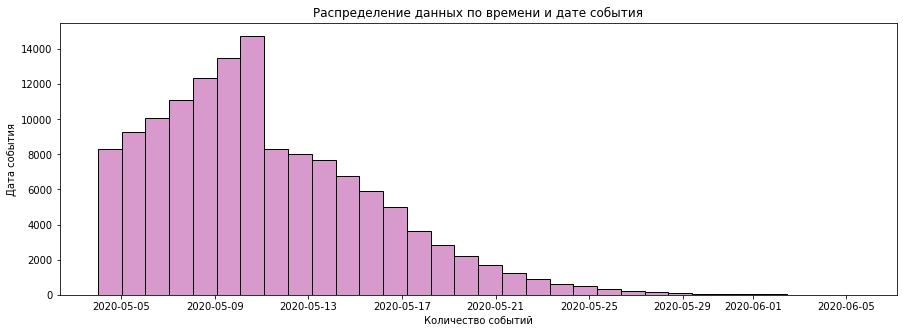

In [37]:
distribution(
    data=data['event_datetime'],
    title='Распределение данных по времени и дате события',
    x_name='Количество событий',
    y_name='Дата события',
    bins=32)

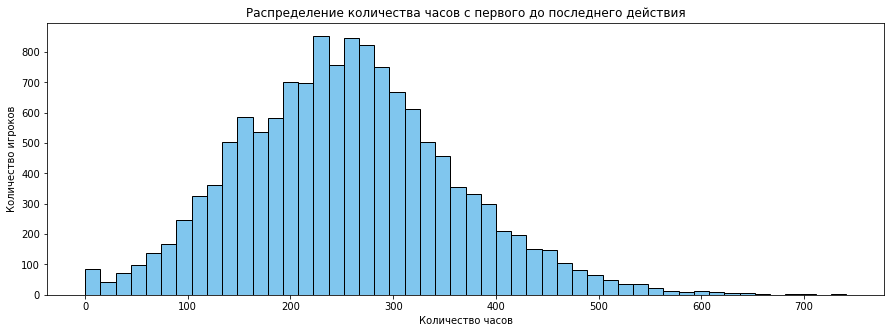

In [38]:
distribution(
    data=(
        data.groupby('user_id')
        .agg({'period_hours' : 'mean'})['period_hours']
    ),
    title='Распределение количества часов с первого до последнего действия',
    x_name='Количество часов',
    y_name='Количество игроков',
    bins=50)

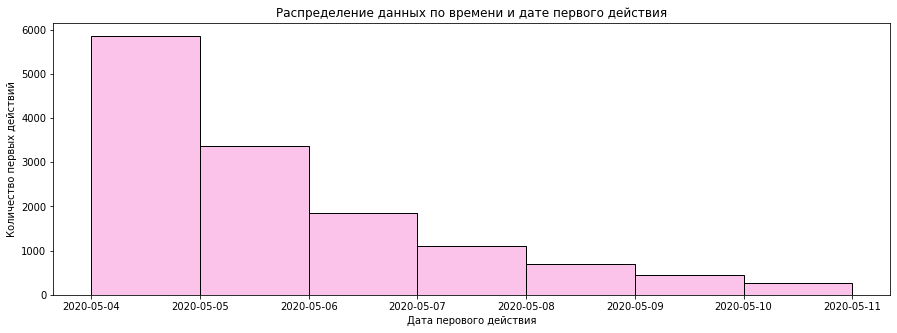

In [39]:
distribution(
    data=(
        data.groupby('user_id')
        .agg({'first_event_dt' : 'first'})['first_event_dt']
    ),
    title='Распределение данных по времени и дате первого действия',
    x_name='Дата перового действия',
    y_name='Количество первых действий',
    bins=7)

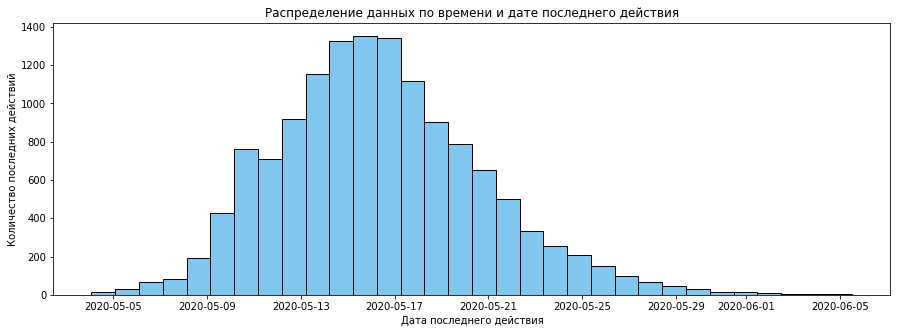

In [40]:
distribution(
    data=(
        data.groupby('user_id')
        .agg({'last_event_dt' : 'first'})['last_event_dt']
    ),
    title='Распределение данных по времени и дате последнего действия',
    x_name='Дата последнего действия',
    y_name='Количество последних действий',
    bins=32)

* По общему распределению видно, что количество событий увеличивалось с 05.05 по 10.05, затем наблюдается резкий спад. В этот день закончились рекламные кампании.

* Распределение количества часов между первым и последним действиями является нормальным с небольшим хвостом. Большая часть игроков находится на первом уровне 200 - 300 часов, или 8 - 12 дней.

* Распределение по времени первых действий все время идет на спад, а хотелось бы видеть что-то близкое к равномерному. Возможно, это как-то связано с финансированием рекламы.

* Распределение времени последних действий является нормальным с небольшим хвостом. Можно сказать, что те, кто пришел в первые дни, не уходили или не проходили уровень сразу. Распределение вполне сочетается с медианным значением периода от первого действия до последнего в 10 дней, т.к. пик последних действий наблюдается 15.05.

Создадим функцию для визуализации категориальных значений и применим ее к соответствующим колонкам.

In [41]:
def barplots(
    col_name, agg_col, agg_type, color,
    percent=True, data=data):

# группируем данные
    df = (
        data
        .groupby(col_name)
        .agg({agg_col : agg_type})
        .rename(columns={agg_col : agg_type})
        .sort_values(by=agg_type, ascending=False)
    )
    
# добавляем колонку с процентами, если требуется
    if percent == True:
        df['percent'] = (df[agg_type] / df[agg_type].sum() * 100).astype('int')
        
# выводим таблицу
    display(df)
    print()

# визуализируем сгруппированные данные

    plt.figure(figsize=(7, 5))
    sns.barplot(data=df, x=df.index, y=df[agg_type], color=color)
    plt.title('{} {} by {}'.format(agg_type, agg_col, col_name))
    plt.xlabel('{}'.format(col_name))
    plt.ylabel('{} {}'.format(agg_type, agg_col))
    plt.show()

,count,percent
event,,
building,127956,94
finished_stage_1,5817,4
project,1866,1


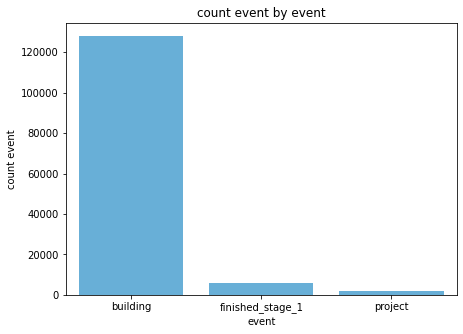

In [42]:
# применяем функцию для событий
barplots(
    col_name='event',
    agg_col='event',
    agg_type='count',
    percent=True,
    color=random.choice(colors_common))
print()

,count,percent
building_type,,
spaceport,59325,46
assembly_shop,54494,42
research_center,14137,11


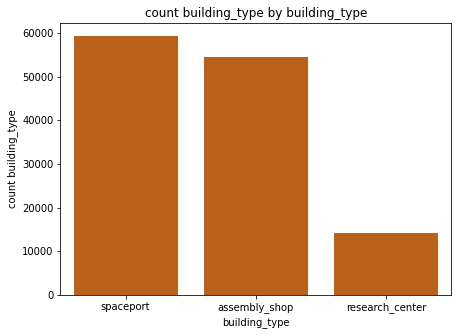

In [43]:
# применяем функцию для типов зданий
barplots(
    data=data.query('building_type != "not_building"'),
    col_name='building_type',
    agg_col='building_type',
    agg_type='count',
    percent=True,
    color=random.choice(colors_common))
print()

,nunique,percent
finished_type,,
not_finished_victory,7759,57
finished_victory,3951,29
finished_project,1866,13


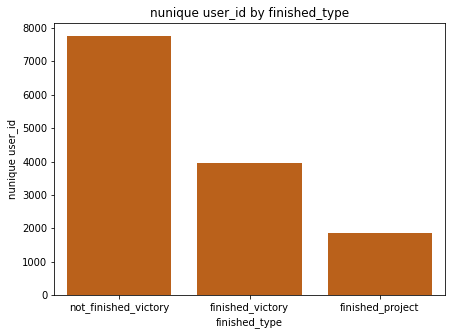

In [44]:
# применяем функцию для типов завершения уровня
barplots(
    col_name='finished_type',
    agg_col='user_id',
    agg_type='nunique',
    percent=True,
    color=random.choice(colors_common))
print()

* 94% событий составляет строительство объектов. Учитывая, что рекламу планируют добавить именно на этом этапе, это может быть очень прибыльным, с одной стороны, а с другой - отталкивать игроков из-за слишком частого показа рекламы. 1% событий - завершение проекта, 4% - завершение уровня.

* Игроки строят spaceports в 46% случаев, assembly_shops - в 42%, а research_centers меньше всего - в 11% случаев.

* 13% пользователей завершают первый уровень проектом, 29% - победой над соперником, а 57% - не завершаю первый уровень.

Посмотрим, всегда ли после события `project` наступает событие `finished_stage_1`. Для этого выберем строки пользователей, которые завершили уровень проектом, отсортируем их по времени, сгруппируем по id и отберем последние две строки.

In [45]:
(
    data.query('user_id in @users_finished_project')
    .sort_values(by=['user_id', 'event_datetime'])
    .groupby(['user_id']).tail(2)['event'].value_counts()
)

finished_stage_1    1866
project             1135
building             731
Name: event, dtype: int64

Реализация проекта не всегда означает завершение уровня, могут потребоваться еще постройки.

Мы определили, что все, кто реализовывал проект, прошли первый уровень. Попробуем посмотреть, можно ли определить на каком-то этапе игры, по какой стратегии движется игрок. Это могло бы помочь определить тех, кто не смог реализовать проект.

In [46]:
# группируем и сортируем данные для тех, кто победил соперника

df_victory = (
    data.query(
        'user_id in @users_finished_victory and building_type != "not_building"'
        ).sort_values(by=['user_id', 'event_datetime'])
)

# добавляем колонку с порядковым номером действия для каждого игрока,
# формируем сводную таблицу с количеством построенных зданий опеределенного
# типа для каждого порядкового действия, удаляем индекс

df_victory = df_victory.assign(
    idx=df_victory.groupby('user_id').cumcount()
    ).pivot_table(
        index='idx', columns='building_type', values='event', aggfunc='count'
        ).reset_index(drop=True)

In [47]:
# группируем и сортируем данные для тех, кто реализовал проект

df_project = (
    data.query(
        'user_id in @users_finished_project and building_type != "not_building"'
        ).sort_values(by=['user_id', 'event_datetime'])
)

# добавляем колонку с порядковым номером действия для каждого игрока;
# формируем сводную таблицу с количеством построенных зданий опеределенного
# типа для каждого порядкового действия;
# удаляем индекс и переворачиваем таблицу

df_project = df_project.assign(
    idx=df_project.groupby('user_id').cumcount()
    ).pivot_table(
        index='idx', columns='building_type', values='event', aggfunc='count'
        ).reset_index(drop=True)

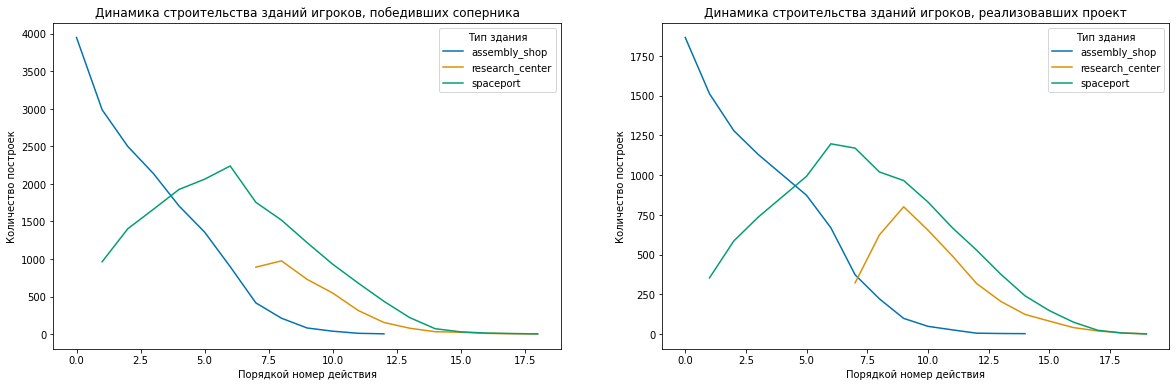

In [48]:
# строим графики

plt.figure(figsize=(20, 6))
sns.set_palette(colors_common)

ax1 = plt.subplot(1, 2, 1)

# строим динамику строительства для каждого типа здания
# при победе над соперником
for col in df_victory.columns:
    sns.lineplot(data=df_victory, x=df_victory.index, y=col)

plt.legend(title='Тип здания', loc='upper right', labels=df_victory.columns)
plt.title('Динамика строительства зданий игроков, победивших соперника')
plt.xlabel('Порядкой номер действия')
plt.ylabel('Количество построек')

ax2 = plt.subplot(1, 2, 2)

# строим динамику строительства для каждого типа здания
# при реализации проекта
for col in df_project.columns:
    sns.lineplot(data=df_project, x=df_project.index, y=col, legend=True)

plt.legend(title='Тип здания', loc='upper right', labels=df_victory.columns)
plt.title('Динамика строительства зданий игроков, реализовавших проект')
plt.xlabel('Порядкой номер действия')
plt.ylabel('Количество построек')

plt.show()

* Единственное отличие, по которому можно было бы разделить игроков по стратегиям - это строительство assembly_shop. При победе над соперником его перестают строить после 12-го дейстия, а при реализации проекта - после 14-го.


* Но ранее мы определили, что среднее количество построек для победы над соперником - 9, а для реализации проекта - 12, поэтому, применив результат анализа графика, мы отсечем основную массу игроков, которые хотели реализовать проект.

    Таким образом, мы не можем разделить игроков по стратегиям в процессе игры.

Посмотрим, сколько в среднем понадобилось построить зданий для завершения уровня.

In [49]:
(
    data.query('event == "building"')
    .pivot_table(
        index='user_id',
        columns='finished_type',
        values='event',
        aggfunc='count'
        ).mean()
)

finished_type
finished_project        12.647910
finished_victory         9.411541
not_finished_victory     8.657043
dtype: float64

Для реализации проекта необходимо построить 12 зданий. Помним, что все, кто реализовывал проект, завершили уровень.

Чтобы завершить уровень победой над соперником, необходимо построить 9 зданий.

Игроки, не завершившие уровень, в среднем строили 8 зданий.


Теперь посмотрим, отличается ли среднее время прохождения уровня через реализацию проекта и через победу над соперником, а также время нахождения в игре тех, кто не прошел уровень.

In [50]:
# создаем функцию для визуализации "ящика с усами"
def boxplots(data, x_col, y_col, color, 
             source_name='', table=True):

# группируем данные для таблицы
    df = (
        data
        .groupby(y_col)
        .agg({x_col : 'mean'})
        .rename(columns={x_col : 'mean'})
        .sort_values(by='mean', ascending=False)
    )
    
# если необходима таблица
    if table == True:
        display(df)
        print()
        
# визуализируем данные
        plt.figure(figsize=(7, 5))
        sns.boxplot(
            data=data, x=data[x_col], y=data[y_col], color=color)
        plt.title('{} by {}'.format(y_col, x_col))

        plt.show()

# если таблица не нужна
    else:
        print('Mean {} for {}: {}'.format(
            x_col, source_name,
            round(df['mean'].mean())
        )
             )

# визуализируем данные
        plt.figure(figsize=(7, 5))
        sns.boxplot(
            data=data, x=data[x_col], color=color)

        plt.show()

,mean
finished_type,
finished_project,322.513398
finished_victory,266.010630
not_finished_victory,234.417193


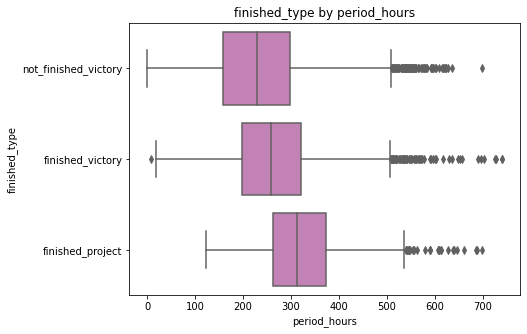

In [51]:
boxplots(
    data=(
        data.groupby('user_id')
        .agg({'period_hours' : 'mean',
              'finished_type' : 'first',
              'source' : 'first'})
        .reset_index()
        ),
    x_col='period_hours',
    y_col='finished_type',
    color=random.choice(colors_common)
    )

Как и предполагалось, больше зданий - больше времени в игре.

Для окончания уровня проектом требуется 322.5 часа, или 13 дней.

Для завершения уровня победой над соперником - 266 часов, или 11 дней.

Бросают первый уровень через 234 часа, или почти 10 дней.

Посмотрим, сколько в среднем времени тратят игроки на строительство одного здания.

,mean
finished_type,
finished_victory,30.066060
not_finished_victory,29.965612
finished_project,26.120694


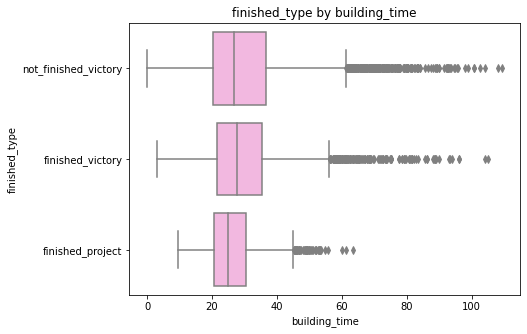

In [52]:
# группируем данные, находим количество построенных зданий для каждого
# игрока, время нахождения в игре и тип завершения уровня
one_building_time = (
    data.query('event == "building"')
    .groupby('user_id')
    .agg(
        {'event' : 'count', 'period_hours' : 'mean', 'finished_type' : 'first'}
         )
)

# добавляем колонку со средним значением времени постройки одного здания
one_building_time['building_time'] = (
    one_building_time['period_hours'] / one_building_time['event']
)

# визуализируем полученные данные
boxplots(
    data=one_building_time,
    x_col='building_time',
    y_col='finished_type',
    color=random.choice(colors_common)
    )

Несмотря на то, что игроки, реализующие проект, проходят уровень дольше на 44 часа, чем те, кто завершает уровен победой над соперником, их игра более динамичная. Такие игроки строят новое здание каждые 26 часов, а остальные - 30.

<div style="border:solid orangered 1px; padding: 20px">

**Итоги общего анализа поведения игроков**

1. Временное распределение:

* У общего распределения наблюдается рост до 10.05, а затем резкий спад, т.к. закончились рекламные кампании.

* Распределение первых событий все время идет на спад. Это может быть связано с финансированием рекламных кампаний. 

* Распределение последних действий по времени и распределение количества часов между первым и последним действиями являются нормальными с небольшим хвостом. Большая часть игроков находится на первом уровне 200 - 300 часов, или 8 - 12 дней.

2. Процентное распределение между событиями:

* 94% событий составляет строительство объектов. 1% событий - завершение проекта, 4% - завершение уровня.

* Игроки строят spaceports в 46% случаев, assembly_shops - в 42%, а research_centers меньше всего - в 11% случаев.

* 13% пользователей завершают первый уровень проектом, 29% - победой над соперником, а 57% - не завершаю первый уровень.

3. Закономерности стратегий игры:
* Для прохождения уровня реализацией проекта в среднем требуется потратить 13 дней и построить 12 зданий с частотой в 26 часов. Реализация проекта не всегда означает завершение уровня, могут потребоваться еще постройки.

* Для прохождения уровня победой над соперником в среднем требуется потратить 11 дней и построить 9 зданий с частотой в 30 часов.
Чтобы завершить уровень победой над соперником, необходимо построить 9 зданий.

* В среднем игроки перестают играть через 9 - 10 дней, построив 8 - 9 зданий с частотой в 30 часов.

* Разделить игроков по категориям "завершит уровень реализацией проекта", "завершит уровень победой над соперником" и "не завершит уровень" в процессе игры невозможно, только по факту прохождения уровня.

</div>

### Анализ поведения пользователей по каналам привлечения
<a class='anchor' id='ad_beh'></a>

Посмотрим на поведение игроков в зависимости от того, с какого канала привлечения они пришли. Будем смотреть на те же показатели, которые были рассмотрены в общем анализе.

Начнем с времени, проведенного в игре.

Mean period_hours for facebook_ads: 257


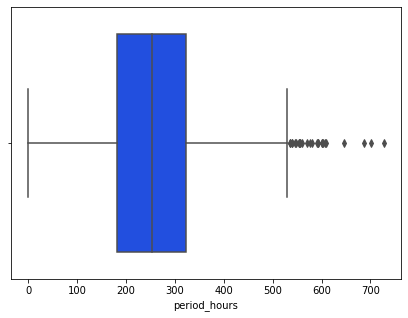

--------------------------------------------------
Mean period_hours for instagram_new_adverts: 258


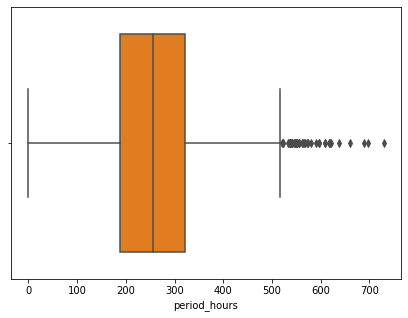

--------------------------------------------------
Mean period_hours for yandex_direct: 254


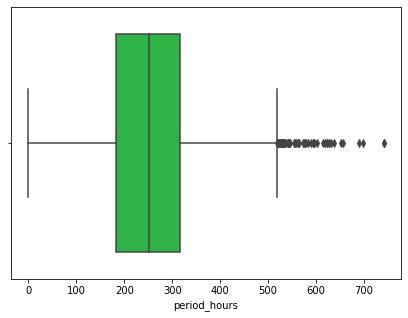

--------------------------------------------------
Mean period_hours for youtube_channel_reklama: 254


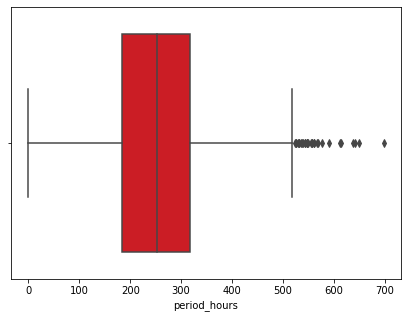

--------------------------------------------------


In [53]:
# зададим переменную для индекса цвета в colors_ad
i = -1

# сортируем список источников по алфавиту для совпадения цветов во всем разделе
for source in sorted(list(data['source'].unique())):

# добавляем номер индекса
    i += 1

# визуализируем "ящик с усами"
    boxplots(
        data=(
            data.query('source == @source')
            .groupby('user_id')
            .agg({'period_hours' : 'mean'})
        ),
        x_col='period_hours',
        y_col='user_id',
        table=False,
        source_name=source,
        color=colors_ad[i]
    )
    
    print('-'*50)

В среднем больше всего времени в игре провели пользователи из Instagram - 258 часов, меньше всего - пользователи из Yandex и YouTube - по 254 часа. Данные значения находятся между 10.5 - 11 днями. Распределение у всех нормальное, с примерно одинаковым диапазоном.

Посмотрим на  относительное соотношение количества событий для игроков из разных источников.

In [54]:
# создаем функцию для группироки данных
# и их визуализации
def source_plot(index, values, aggfunc, data=data):

# группируем данные
    df = data.pivot_table(
        index=index,
        columns='source',
        values=values,
        aggfunc=aggfunc
    )
    
# заменяем количественные данные на проценты  
    for col in df.columns:
        df[col] = (
            df[col] / df[col].sum(axis=0) * 100
        )

# строим график
    df.T.plot(
    kind='bar', figsize=(15, 5), stacked=True,
    width=0.8, color=colors_common
    )
    
    plt.title(
        'Процентное соотношение {} по каналам привлечения'
        .format(index))
    
    plt.xlabel('Канал привлечения')
    plt.ylabel('Проценты')
    plt.xticks(rotation=0)

    plt.show()

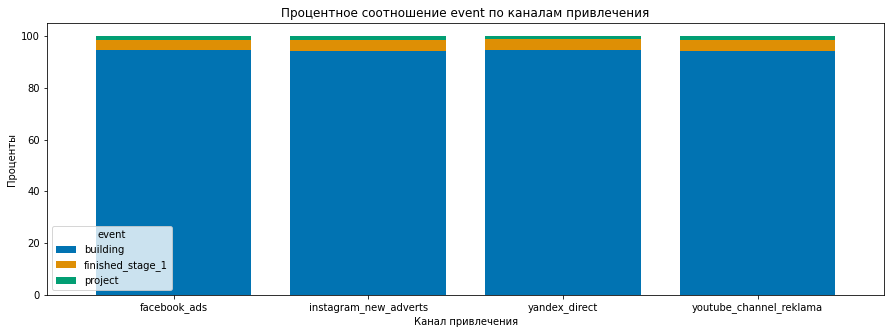

In [55]:
# применяем функцию для типов событий
source_plot('event', 'event_datetime', 'count')

Относительные величины не отличаются для пользователей из разных каналов привлечения и, соответственно, не отличаются от общих показателей:

94% событий составляет строительство объектов;

4% - завершение уровня;

1% событий - завершение проекта.

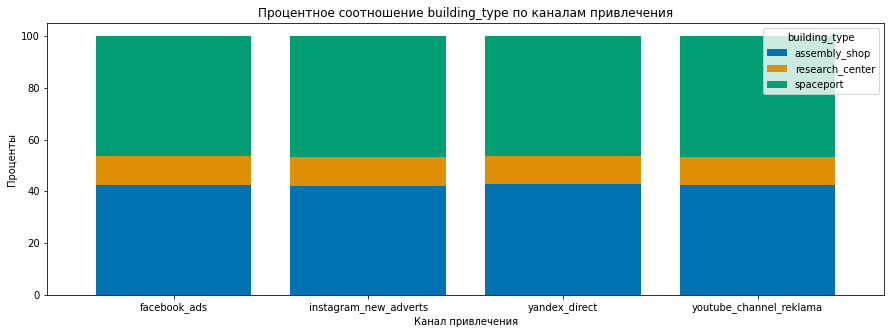

In [56]:
# применяем функцию для типов зданий
source_plot(
    data=data.query('building_type != "not_building"'),
    index='building_type',
    values='event_datetime',
    aggfunc='count'
)

Строительство зданий тоже не зависит от источника, из которого пришли игроки: игроки строят spaceports в 46% случаев, assembly_shops - в 42%, а research_centers - в 11% случаев.

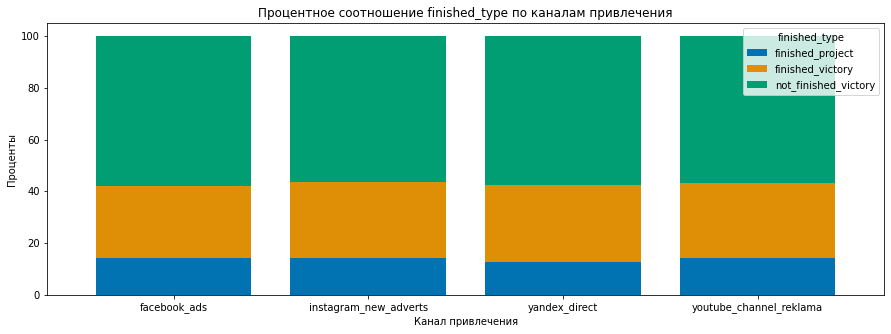

In [57]:
# применяем функцию для типов завершения уровня
source_plot('finished_type', 'user_id', 'nunique')

Напомним общие показатели способа завершения уровня:

13% пользователей завершают первый уровень проектом;

29% - победой над соперником;

57% - не завершаю первый уровень.

Здесь также максимальное различие в +-1%, т.е. стратегия игрока не зависит от канала привлечения.

Посмотрим на количество построенных зданий для игроков из разных каналов привлечения в зависимости от способа завершения уровня.

In [58]:
for source in sorted(list(data['source'].unique())):
    
    print(
        'Среднее количество построенных зданий\nв зависимости от способа завершения уровня для {}'
        .format(source)
        )
    
    print()
    
    print(
        data.query('source in @source and event == "building"')
        .pivot_table(
            index='user_id',
            columns='finished_type',
            values='event',
            aggfunc='count'
            ).mean()
    )

    print()

Среднее количество построенных зданий
в зависимости от способа завершения уровня для facebook_ads

finished_type
finished_project        12.649616
finished_victory         9.429513
not_finished_victory     8.901015
dtype: float64

Среднее количество построенных зданий
в зависимости от способа завершения уровня для instagram_new_adverts

finished_type
finished_project        12.756303
finished_victory         9.400000
not_finished_victory     8.738437
dtype: float64

Среднее количество построенных зданий
в зависимости от способа завершения уровня для yandex_direct

finished_type
finished_project        12.595161
finished_victory         9.375527
not_finished_victory     8.609369
dtype: float64

Среднее количество построенных зданий
в зависимости от способа завершения уровня для youtube_channel_reklama

finished_type
finished_project        12.596306
finished_victory         9.474359
not_finished_victory     8.391618
dtype: float64



Здесь тоже никаких различий.

Теперь посмотрим, отличается ли среднее время прохождения уровня в зависимости от стратегии игроков из разных каналов привлечения.

Среднее время прохождения уровня
в зависимости от способа завершения уровня для facebook_ads



,mean
finished_type,
finished_project,321.644501
finished_victory,264.745718
not_finished_victory,237.320431


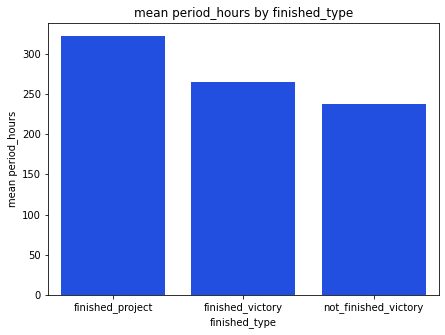


Среднее время прохождения уровня
в зависимости от способа завершения уровня для instagram_new_adverts



,mean
finished_type,
finished_project,324.283613
finished_victory,266.079798
not_finished_victory,237.723020


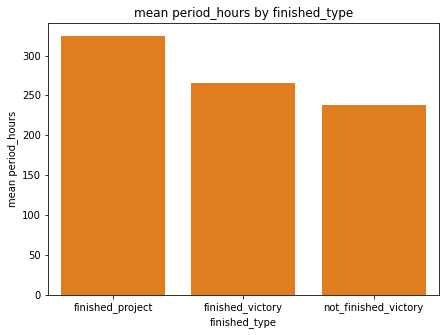


Среднее время прохождения уровня
в зависимости от способа завершения уровня для yandex_direct



,mean
finished_type,
finished_project,320.279032
finished_victory,266.606892
not_finished_victory,233.212613


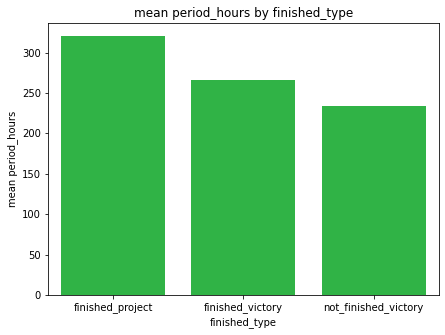


Среднее время прохождения уровня
в зависимости от способа завершения уровня для youtube_channel_reklama



,mean
finished_type,
finished_project,324.841689
finished_victory,266.066667
not_finished_victory,229.537656


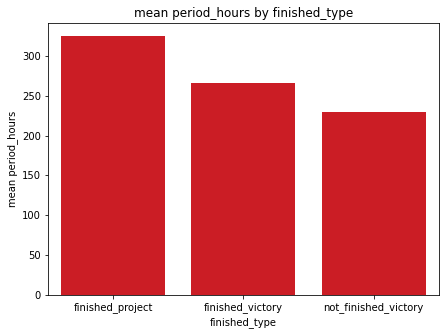

In [59]:
i = -1

for source in sorted(list(data['source'].unique())):

    i +=1

    print(
        'Среднее время прохождения уровня\nв зависимости от способа завершения уровня для {}'
        .format(source)
        )
    
    print()
    
    barplots(
        data=(
            data.groupby('user_id')
            .agg({'period_hours' : 'mean',
                  'finished_type' : 'first',
                  'source' : 'first'})
            .reset_index()
            .query('source in @source')
        ),
        col_name='finished_type',
        agg_col='period_hours',
        agg_type='mean',
        percent=False,
        color=colors_ad[i]
        )

    print()


Различия во времени прохождения уровней между пользователями, пришедшими из разных каналов, незначительны.

*Для справки:*
* *Раньше всего прохождение уровня бросают пользователи из YouTube и Yandex: через 229.5 и 233 часа соответственно. Пользователи из Facebook и Instagram задерживаются до 237 часов.*
* *Пользователи из Facebook побеждают соперника немного быстрее - за 264 часа, а остальные - 266 часов.*
* *Быстрее всех проект реализовывают игроки, пришедшие из Yandex, - за 320 часов, пользователи из Facebook - за 321.5 часов, а остальные - за 324 часа.*

Посмотрим, сколько в среднем времени тратят игроки на строительство одного здания.

Среднее время строительства одного здания
в зависимости от способа завершения уровня для facebook_ads



,mean
finished_type,
finished_victory,29.752323
not_finished_victory,29.610745
finished_project,26.074828


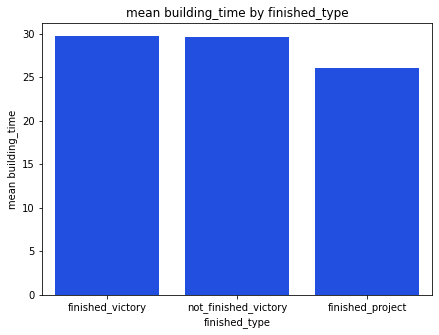


Среднее время строительства одного здания
в зависимости от способа завершения уровня для instagram_new_adverts



,mean
finished_type,
finished_victory,30.157869
not_finished_victory,30.064055
finished_project,25.980038


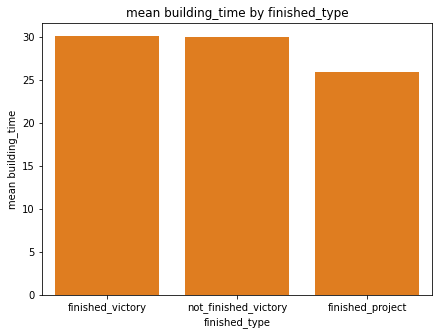


Среднее время строительства одного здания
в зависимости от способа завершения уровня для yandex_direct



,mean
finished_type,
finished_victory,30.265946
not_finished_victory,30.021414
finished_project,26.037244


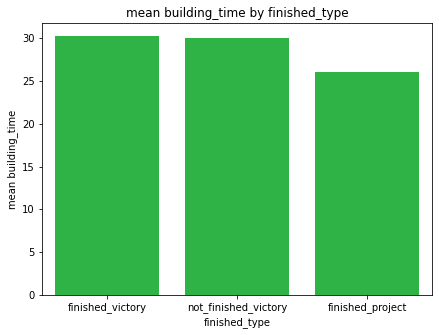


Среднее время строительства одного здания
в зависимости от способа завершения уровня для youtube_channel_reklama



,mean
finished_type,
not_finished_victory,30.109191
finished_victory,29.890417
finished_project,26.481181


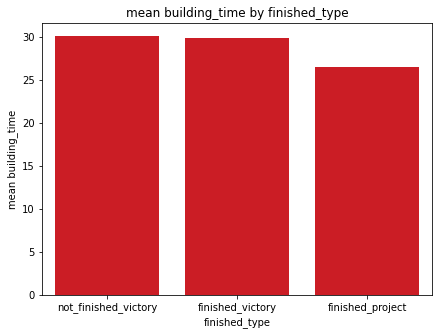

In [60]:
i = -1

for source in sorted(list(data['source'].unique())):

    i += 1
    
    print(
        'Среднее время строительства одного здания\nв зависимости от способа завершения уровня для {}'
        .format(source)
        )
    
    print()  
# группируем данные, находим количество построенных зданий для каждого
# игрока, время нахождения в игре и тип завершения уровня
    one_building_time = (
        data.query('source in @source and event == "building"')
        .groupby('user_id')
        .agg({'event' : 'count',
              'period_hours' : 'mean',
              'finished_type' : 'first'})
        )

# добавляем колонку со средним значением времени постройки одного здания
    one_building_time['building_time'] = (
        one_building_time['period_hours'] / one_building_time['event']
    )

# группируем данные по типу завершения уровня и находим среднее время
# строительства одного здания внутри функции
# для группировки и визуализации
    barplots(
        data=(
            one_building_time.groupby('finished_type')
            .agg({'building_time' : 'mean'})
            .reset_index()
            ),
        col_name='finished_type',
        agg_col='building_time',
        agg_type='mean',
        percent=False,
        color=colors_ad[i]
        )

    print()

В данном случае нет каких-либо различий: игроки из разных источников, реализоввывающие проект, строят новое здание каждые 26 часов, а остальные - 30.

<div style="border:solid orangered 1px; padding: 20px">

**Итоги анализа поведения игроков по каналам привлечения**

1. Различия во времени прохождения уровней между пользователями, пришедшими из разных каналов, незначительны.
    

2. Игроки из разных источников имеют одинаковые показатели по:

* относительному соотношению количества событий;
* количеству построенных зданий в зависимости от его типа;
* стратегии прохождения уровня;
* среднему количеству построенных зданий в зависимости от стратегии;
* среднему времени строительства одного здания в зависимости от стратегии;


</div>

### Анализ трат на рекламные кампании
<a class='anchor' id='ad_source'></a>

Создадим функцию, которая будет рисовать графики динамики трат на рекламные кампании, стоимости привлечения одного пользователя и количества привлеченных пользователей как по всем источникам, так и по отдельности.

In [61]:
def ad_costs(index_col=''):

# если не указано разделение на источники, то таблица ads_costs группируется
# по дням; для каждого дня расчитывается общая сумма трат на рекламу,
# средняя стоимость привлечения одного пользователя и количество привлеченных
# пользователей

    if index_col == '':

        ad_costs_grouped = (
            ads_costs
            .groupby('day')
            .agg({'cost' : 'sum', 'user_cost' : 'mean', 'user_id' : 'sum'})
            .round(2)
            .reset_index()
            )

# по сгруппированным данным строятся соответствующие графики динамики

        plt.figure(figsize=(20, 5))

        ax1 = plt.subplot(1, 3, 1)
        sns.lineplot(
            data=ad_costs_grouped, x='day', y='cost', color=colors_ad[9])
        plt.title('Траты на рекламные кампании')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Сумма, $')

        ax2 = plt.subplot(1, 3, 2)
        sns.lineplot(
            data=ad_costs_grouped, x='day', y='user_cost', color=colors_ad[9])
        plt.ylim(0, 1)
        plt.title('Стоимость привлечения пользователя')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Сумма, $')

        ax3 = plt.subplot(1, 3, 3)
        sns.lineplot(
            data=ad_costs_grouped, x='day', y='user_id', color=colors_ad[9])
        plt.title('Количество привлеченных пользователей')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Количество пользователей')

        plt.show()

# если указано разделение по ресурсам или другому признаку, то графики строятся
# по таблице ads_costs с параметром hue

    else:
        plt.figure(figsize=(20, 5))

        ax1 = plt.subplot(1, 3, 1)
        sns.set_palette(colors_ad)
        sns.lineplot(
            data=ads_costs, x='day', y='cost', hue=index_col)
        plt.title('Траты на рекламные кампании')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Сумма, $')

        ax2 = plt.subplot(1, 3, 2)
        sns.set_palette(colors_ad)
        sns.lineplot(
            data=ads_costs, x='day', y='user_cost', hue=index_col)
        plt.ylim(0, 1)
        plt.title('Стоимость привлечения пользователя')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Сумма, $')

        ax3 = plt.subplot(1, 3, 3)
        sns.set_palette(colors_ad)
        sns.lineplot(
            data=ads_costs, x='day', y='user_id', hue=index_col)
        plt.title('Количество привлеченных пользователей')
        plt.xticks(rotation=-45)
        plt.xlabel('Дата')
        plt.ylabel('Количество пользователей')

        plt.show()

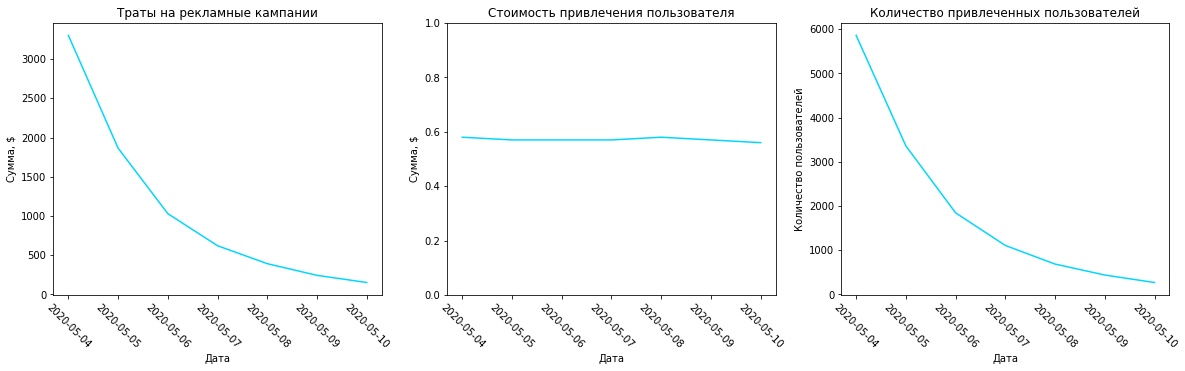

In [62]:
ad_costs()

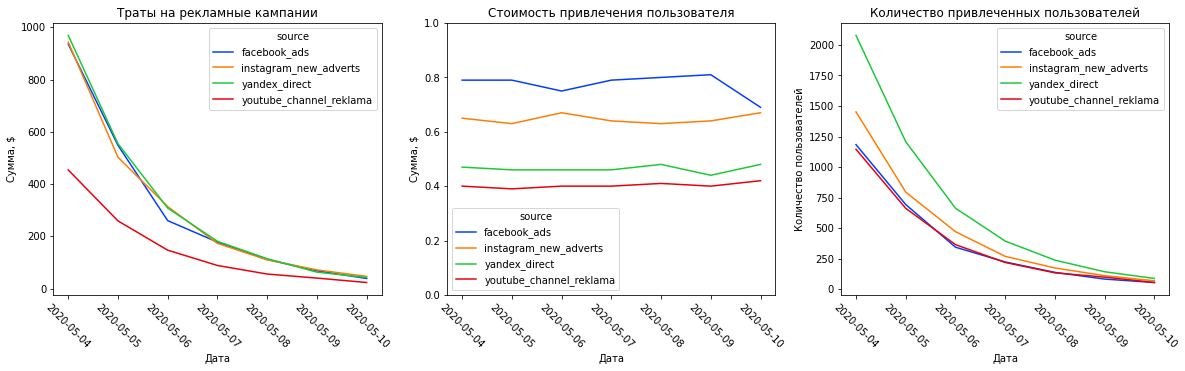

In [63]:
ad_costs('source')

<div style="border:solid orangered 1px; padding: 20px">

**Итоги анализа трат на рекламу**

* Теория о том, что постоянный спад распределения первых событий связан с финансированием рекламных кампаний, подтвердилась. Общие траты на рекламу в период 04.05 - 10.05 упали с 3300 у.е. до 150 у.е. При сохранении средней стоимости привлечения одного пользователя в 0.56 - 0.58 у.е. это дало соответствующий спад количества новых пользователей с 5800 до 270 в день.

    
* Меньше всего финансировалась реклама на YouTube 450 - 25 у.е. Стоимость привлечения одного пользователя также самая дешевая: 0.39 - 0.42 у.е. При этом количество пришедших пользователей (1150 - 56) хоть и самое низкое, но такое же, как и у самых дорогих пользователей, пришедших из Facebook.

    
* На рекламу в Facebook, Instagram и Yandex потратили примерно одинаковые суммы в промежутке от 935, 943, 970 у.е. до 38, 46, 42 у.е. соответственно.

    
* Самые дорогие пользователи пришли из Facebook. Их стоимость варировалась от 0.75 у.е. до 0.81 у.е. в сочетании с низким количеством пришедших пользователей. 10.05 стоимость снизилась до 0.69 у.е. 

    
* Стоимость привлечения пользователя из Instagram составила 0.63 - 0.67 у.е., а количество пришедших пользователей - 1450 - 70.

    
* Больше всего пользователей пришло из Yandex: 2070 - 90. Это хороший показатель при относительной дешевизне привлечения одного пользователя в 0.44 - 0.48 у.е.
    
    
* Нельзя сделать 100%-ый вывод о том, какая рекламная кампания оказалась самой успешной, поскольку финансирование все время снижалось из-за чего и снижалось количество привлеченных пользователей. На маленькой выборке делать выводы не стоит.

</div>

## Проверка гипотез
<a class='anchor' id='hyp'></a>

### Отличается ли время завершения уровня при реализации проекта и при победе над первым игроком?
<a class='anchor' id='hyp_1'></a>

Сформируем нулевую и альтернативную гипотезу.

**Н0:** Нет различий между временем завершения уровня проектом и временем завершения уровня победой над соперником.

**Н1:** Есть различия между временем завершения уровня проектом и временем завершения уровня победой над соперником.

Будем использовать тест Манна-Уитни, поскольку в данных есть небольшие выбросы. При анализе было определено, что они не сильно влияют на средние значения, но на тест Стьюдента повлиять могут.

Установим критическое значение уровня значимости в 0.05.

In [64]:
# формируем данные для тех, кто завершил уровень проектом

project_hours = (
    data.query('finished_type == "finished_project"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

# формируем данные для тех, кто завершил уровень победой над соперником

victory_hours = (
    data.query('finished_type == "finished_victory"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

In [65]:
# создаем функцию для теста Манн-Уитни и визуализации распределения

def mw_test(df_1, df_2, df_1_name, df_2_name, alpha=0.05,
           box=True):

# проводим тест
    U, p_value = mannwhitneyu(df_1, df_2, alternative='two-sided')

# строим графики распределения
    if box == False:
        
        plt.figure(figsize=(7, 3))
        sns.histplot(data=df_1, bins=50, color=random.choice(colors_common))
        plt.title(
            'Распределение времени завершения игры {}'
            .format(df_1_name)
        )
        plt.show()
        
        plt.figure(figsize=(7, 3))
        sns.histplot(data=df_2, bins=50, color=random.choice(colors_common))
        plt.title(
            'Распределение времени завершения игры {}'
            .format(df_2_name)
        )
        plt.show()

# строим "ящики с усами"
    else:
        
        plt.figure(figsize=(5, 5))
        sns.boxplot(
        data=df_1, color=random.choice(colors_common)
        )
        plt.title(
            'Распределение времени завершения игры {}'
            .format(df_1_name)
        )
        plt.show()

        plt.figure(figsize=(5, 5))
        sns.boxplot(
        data=df_2, color=random.choice(colors_common)
        )
        plt.title('Распределение времени завершения игры {}'
                  .format(df_2_name)
                 )
        plt.show()
    
    print('-'*50)

# выводим средние значения и вывод по тесту   
    print(
        'Среднее время завершения игры {}: {}'
        .format(df_2_name, round(df_2.mean()))
        )
    
    print(
        'Среднее время завершения игры {}: {}'
        .format(df_1_name, round(df_1.mean()))
        )
    
    print('Уровень статистической значимости: ', round(p_value, 5))
        
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

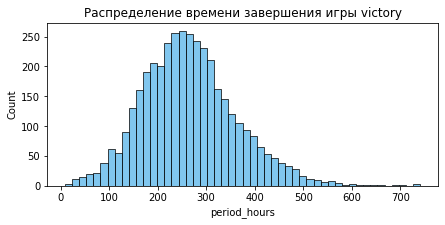

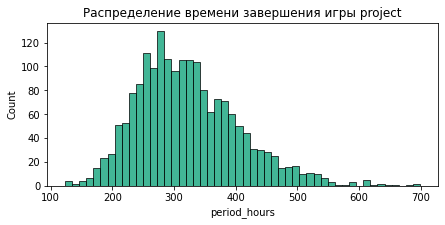

--------------------------------------------------
Среднее время завершения игры project: 323
Среднее время завершения игры victory: 266
Уровень статистической значимости:  0.0
Отвергаем нулевую гипотезу: разница статистически значима


In [66]:
# применяем функцию

mw_test(
    victory_hours, project_hours,
    df_1_name='victory', df_2_name='project',
    alpha=0.05, box=False
    )

Уровень статистической значимости настолько мал, что даже при округлении до пяти цифр после запятой он равняется нулю.

Таким образом, мы еще раз подтвердили, что время завершения уровня при реализации проекта и время завершения уровня при победе над первым игроком различаются.

При проверке гипотез о времени, проведенном в игре, игроков из четырех каналов привлечения тоже будем использовать тест Манна-Уитни

Однако критическое значение уровня значимости будет установлено с поправкой Бонферрони. Для четырех каналов потребуется шесть сравнений, значит критическое значение будет равно 0.05/6.

In [67]:
# формируем данные для игроков, пришедших из разных каналов привлечения

yandex_hours = (
    data.query('source == "yandex_direct"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

instagram_hours = (
    data.query('source == "instagram_new_adverts"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

facebook_hours = (
    data.query('source == "facebook_ads"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

youtube_hours = (
    data.query('source == "youtube_channel_reklama"')
    .groupby('user_id')
    .agg({'period_hours' : 'mean'})
    ['period_hours']
)

**Н0:** Нет различий между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из Instagram.

**Н1:** Есть различия между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из Instagram.

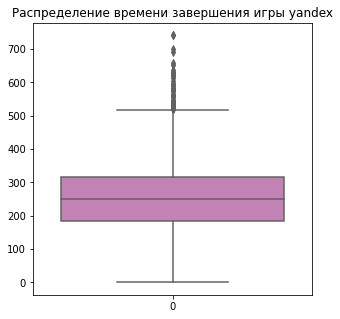

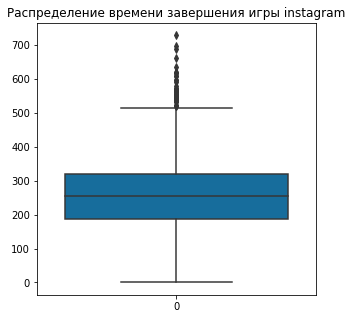

--------------------------------------------------
Среднее время завершения игры instagram: 258
Среднее время завершения игры yandex: 254
Уровень статистической значимости:  0.06842
Не получилось отвергнуть нулевую гипотезу


In [68]:
mw_test(
    yandex_hours, instagram_hours,
    df_1_name='yandex', df_2_name='instagram',
    alpha=0.05/6
    )

**Н0:** Нет различий между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из Facebook.

**Н1:** Есть различия между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из Facebook.

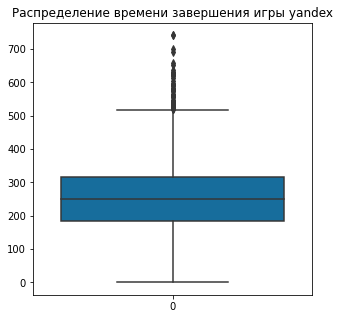

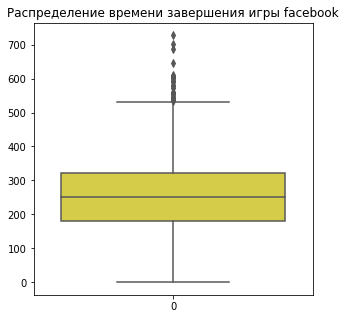

--------------------------------------------------
Среднее время завершения игры facebook: 257
Среднее время завершения игры yandex: 254
Уровень статистической значимости:  0.27615
Не получилось отвергнуть нулевую гипотезу


In [69]:
mw_test(
    yandex_hours, facebook_hours,
    df_1_name='yandex', df_2_name='facebook',
    alpha=0.05/6
    )

**Н0:** Нет различий между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из YouTube.

**Н1:** Есть различия между временем пребывания в игре игроков из Yandex и временем пребывания в игре игроков из YouTube.

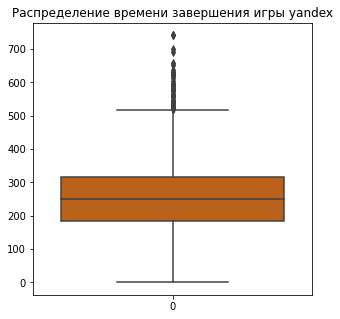

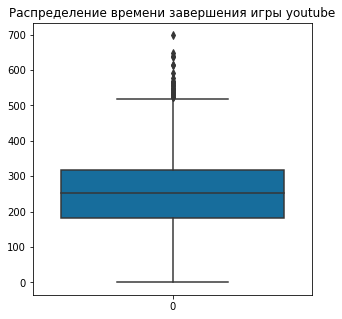

--------------------------------------------------
Среднее время завершения игры youtube: 254
Среднее время завершения игры yandex: 254
Уровень статистической значимости:  0.94012
Не получилось отвергнуть нулевую гипотезу


In [70]:
mw_test(
    yandex_hours, youtube_hours,
    df_1_name='yandex', df_2_name='youtube',
    alpha=0.05/6
    )

**Н0:** Нет различий между временем пребывания в игре игроков из Facebook и временем пребывания в игре игроков из Instagram.

**Н1:** Есть различия между временем пребывания в игре игроков из Facebook и временем пребывания в игре игроков из Instagram.

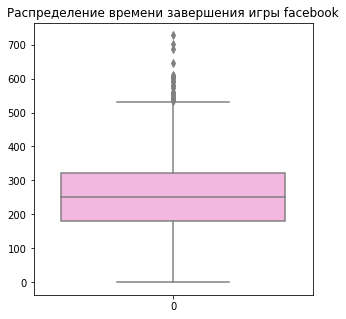

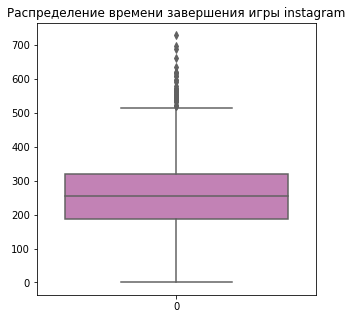

--------------------------------------------------
Среднее время завершения игры instagram: 258
Среднее время завершения игры facebook: 257
Уровень статистической значимости:  0.58275
Не получилось отвергнуть нулевую гипотезу


In [71]:
mw_test(
    facebook_hours, instagram_hours,
    df_1_name='facebook', df_2_name='instagram',
    alpha=0.05/6
    )

**Н0:** Нет различий между временем пребывания в игре игроков из YouTube и временем пребывания в игре игроков из Instagram.

**Н1:** Есть различия между временем пребывания в игре игроков из YouTube и временем пребывания в игре игроков из Instagram.

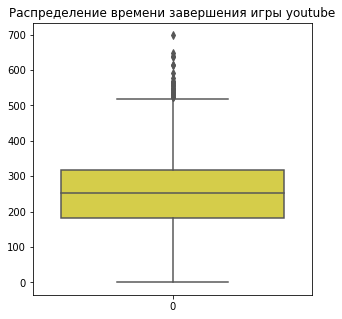

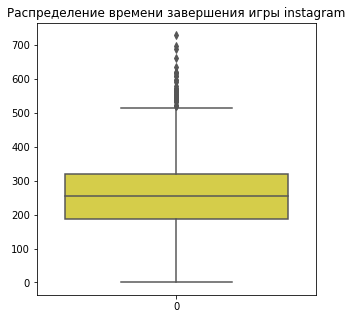

--------------------------------------------------
Среднее время завершения игры instagram: 258
Среднее время завершения игры youtube: 254
Уровень статистической значимости:  0.13609
Не получилось отвергнуть нулевую гипотезу


In [72]:
mw_test(
    youtube_hours, instagram_hours,
    df_1_name='youtube', df_2_name='instagram',
    alpha=0.05/6
    )

**Н0:** Нет различий между временем пребывания в игре игроков из Facebook и временем пребывания в игре игроков из YouTube.

**Н1:** Есть различия между временем пребывания в игре игроков из Facebook и временем пребывания в игре игроков из YouTube.

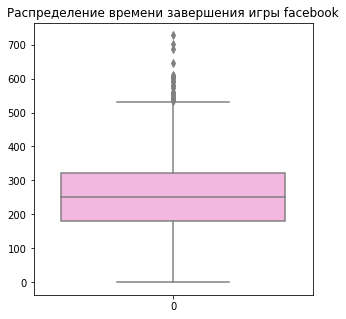

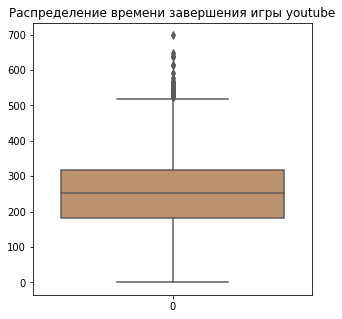

--------------------------------------------------
Среднее время завершения игры youtube: 254
Среднее время завершения игры facebook: 257
Уровень статистической значимости:  0.36259
Не получилось отвергнуть нулевую гипотезу


In [73]:
mw_test(
    facebook_hours, youtube_hours,
    df_1_name='facebook', df_2_name='youtube',
    alpha=0.05/6
    )

Ни в одном из случаев разница не оказалась статистически значима и не были отвергнуты нулевые гипотезы.

Таким образом, время, проведенное в игре, у игроков из разных каналов привлечения не различается.

## Общий вывод и рекомендации
<a class='anchor' id='summary'></a>

**Поведение пользователей:**

1. Большинство игроков находится на первом уровне 200 - 300 часов, или 8 - 12 дней.


2. 13% пользователей завершают первый уровень проектом. Для этого в среднем требуется:

    * 13 дней,
    * 12 построек с частотой строительства в 26 часов.

   Реализация проекта не всегда означает завершение уровня, могут потребоваться еще постройки.
   

3. 29% пользователей завершают первый уровень победой над соперником. Для этого в среднем требуется:

    * 11 дней,
    * 9 построек с частотой строительства в 30 часов.


4. 57% пользователей не завершаю первый уровень. Они в среднем:

    * играют 9 - 10 дней,
    * строят 8 - 9 зданий каждые 30 часов.


5. Разница во времени завершения уровня при реализации проекта и времени завершения уровня при победе над первым игроком является статистически значимой.


6. Разделить игроков по категориям "завершит уровень реализацией проекта", "завершит уровень победой над соперником" и "не завершит уровень" в процессе игры невозможно, только по факту прохождения уровня.


7. 94% событий составляет строительство объектов, 4% - завершение уровня, 1% событий - завершение проекта.


8. Игроки строят spaceports в 46% случаев, assembly_shops - в 42%, а research_centers - в 11% случаев.


9. Меньше всего времени в игре провели пользователи из Yandex и YouTube - по 254 часа, а больше всего из Facebook и Instagram - 257 и 258 часов соответственно. Данные значения находятся между 10.5 - 11 днями.

   Теория о том, что время, проведенное в игре, у игроков из разных каналов привлечения различается, не подтвердилась, т.к. разница не является статистически значимой.

**Траты на рекламные кампании:**


1. Общее распределение событий показывает рост с 04.05 по 10.05, а затем резкий спад, т.к. 10.05 закончились рекламные кампании.

   Распределение первых событий все время идет на спад, что связано с финансированием рекламных кампаний.
   
   Общие траты на рекламу в период 04.05 - 10.05 упали с 3300 у.е. до 150 у.е. При сохранении средней стоимости привлечения одного пользователя в 0.56 - 0.58 у.е. это дало соответствующий спад количества новых пользователей с 5800 до 270 в день.


2. Меньше всего финансировалась реклама на YouTube 450 - 25 у.е. Стоимость привлечения одного пользователя также самая дешевая: 0.39 - 0.42 у.е. При этом количество пришедших пользователей самое низкое: 1150 - 56.


3. На рекламу в Facebook, Instagram и Yandex потратили примерно одинаковые суммы в промежутке от 935, 943, 970 у.е. до 38, 46, 42 у.е. соответственно.


4. Самые дорогие пользователи пришли из Facebook. Их стоимость варировалась от 0.75 у.е. до 0.81 у.е., 10.05 стоимость снизилась до 0.69 у.е. Это сочиталось с низким количеством пришедших пользователей (на уровне YouTube).


5. Стоимость привлечения пользователя из Instagram составила 0.63 - 0.67 у.е., а количество пришедших пользователей - 1450 - 70.


6. Больше всего пользователей пришло из Yandex: 2070 - 90. Это хороший показатель при относительной дешевизне привлечения одного пользователя в 0.44 - 0.48 у.е.

<div style="border:solid orangered 1px; padding: 20px">

**Рекомендации:**

1. 10.05.2020 стоимость привлечения одного пользователя из Facebook резко снизилась до 0.69 у.е. Рекламному отделу следует проверить, менялись ли настройки рекламной кампании. Они могли улучшить определение целевой аудитории.


2. Стоит попробовать не снижать траты на рекламу, а держать их на одинаковом уровне, например, в течение недели-двух. Это позволит посмотреть, какие дни недели привлекают больше пользователей и на каких каналах. Такой подход лучше демонстрирует количество и качество привлекаемых пользователей. Также можно будет провести когортный анализ по дате привлечения. Это будет полезно и при запуске рекламы в игре или другого типа монетизации, чтобы определить LTV и ROI.


3. На данном этапе можно сказать, что рекламная кампания в Yandex является самой успешной. В то же время нельзя быть в этом полностью уверенным, не соблюдая условия, указанные в предыдущем пункте.


4. В проекте говорилось о том, что демонстрация рекламы при выборе типа объекта для строительства может оказаться слишком частой, ведь это действие занимает 94% от всех действий. В то же время, в среднем одно здание строится каждые 26-30 часов, что уже не кажется таким частым событием. Можно попробовать провести A/B-тест и ввести рекламу на этом этапе для части пользователей и определить уменьшается ли время ухода пользователей из игры. Если пользователи будут играть столько же, то рекламу можно внедрять для всех.


5. На будущее можно посмотреть на другие события в игре, их частоту совершения и рассмотреть возможность внедрить рекламу и там. Можно добавить платную подписку, которая исключает показ рекламы.
    
</div>